*This post gives an introduction to functions for extracting data from [Variant Call Format (VCF)](https://samtools.github.io/hts-specs/VCFv4.3.pdf) files and loading into [NumPy](http://www.numpy.org/) arrays, [pandas](http://pandas.pydata.org/) data frames or [HDF5](https://support.hdfgroup.org/HDF5/) files for ease of analysis. These functions are available in [scikit-allel](http://scikit-allel.readthedocs.io/en/latest/) version 1.1 or later. Any feedback or bug reports welcome.*

## Introduction

### Variant Call Format (VCF)

VCF is a widely-used file format for genetic variation data. Here is an example of a small VCF file, based on the example given in the [VCF specification](https://samtools.github.io/hts-specs/VCFv4.3.pdf):

In [1]:
with open('example.vcf', mode='r') as vcf:
    print(vcf.read())

##fileformat=VCFv4.3
##reference=file:///seq/references/1000GenomesPilot-NCBI36.fasta
##contig=<ID=20,length=62435964,assembly=B36,md5=f126cdf8a6e0c7f379d618ff66beb2da,species="Homo sapiens",taxonomy=x>
##INFO=<ID=DP,Number=1,Type=Integer,Description="Total Depth">
##INFO=<ID=AF,Number=A,Type=Float,Description="Allele Frequency">
##INFO=<ID=DB,Number=0,Type=Flag,Description="dbSNP membership, build 129">
##FILTER=<ID=q10,Description="Quality below 10">
##FILTER=<ID=s50,Description="Less than 50% of samples have data">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	NA00001	NA00002	NA00003
20	14370	rs6054257	G	A	29	PASS	DP=14;AF=0.5;DB	GT:DP	0/0:1	0/1:8	1/1:5
20	17330	.	T	A	3	q10	DP=11;AF=0.017	GT:DP	0/0:3	0/1:5	0/0:41
20	1110696	rs6040355	A	G,T	67	PASS	DP=10;AF=0.333,0.667;DB	GT:DP	0/2:6	1/2:0	2/2:4
20	1230237	.	T	.	47	PASS	DP=13	GT:DP	0/0:7	0/0:4	./.:.
20	1234567	

A VCF file begins with a number of meta-information lines, which start with two hash ('##') characters. Then there is a single header line beginning with a single hash ('#') character. After the header line there are data lines, with each data line describing a genetic variant at a particular position relative to the reference genome of whichever species you are studying. Each data line is divided into fields separated by tab characters. There are 9 fixed fields, labelled "CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO" and "FORMAT". Following these are fields containing data about samples, which usually contain a genotype call for each sample plus some associated data. 

For example, the first data line in the file above describes a variant on chromosome 20 at position 14370 relative to the B36 assembly of the human genome. The reference allele is 'G' and the alternate allele is 'A', so this is a single nucleotide polymorphism (SNP). In this file there are three fields with data about samples labelled 'NA00001', 'NA00002' and 'NA00003'. The genotype call in the first sample is '0/0', meaning that individual 'NA0001' is homozygous for the reference allele at this position. The genotype call for the second sample is '0/1' (you may need to scroll across to see this), which means that individual 'NA00002' is heterozygous for the reference and alternate alleles at this position.

### NumPy/pandas/HDF5/...

There are a number of software tools that can read VCF files and perform various analyses. However, if your dataset is large and/or you need to do some bespoke analysis, then it can be faster and more convenient to first extract the necessary data from the VCF file and load into a more efficient storage container.

For analysis and plotting of numerical data in Python, it is very convenient to load data into [NumPy arrays](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html). A NumPy array is an in-memory data structure that provides support for fast arithmetic and data manipulation. For analysing tables of data, [pandas DataFrames](https://pandas.pydata.org/pandas-docs/stable/dsintro.html) provide useful features such as querying, aggregation and joins. When data are too large to fit into main memory, [HDF5 files](http://docs.h5py.org/en/latest/quick.html) and [Zarr arrays](http://zarr.readthedocs.io/en/latest/tutorial.html) can provide fast on-disk storage and retrieval of numerical arrays. 

[scikit-allel](http://scikit-allel.readthedocs.io/en/latest/) is a Python package intended to enable exploratory analysis of large-scale genetic variation data. Version 1.1.0 of scikit-allel adds some new functions for extracting data from VCF files and loading the data into NumPy arrays, pandas DataFrames or HDF5 files. Once you have extracted these data, there are many analyses that can be run interactively on a commodity laptop or desktop computer, even with large-scale datasets from population resequencing studies. To give a flavour of what analyses can be done, there are a few previous articles on my blog, touching on topics including [variant and sample QC](http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html), [allele frequency differentiation](http://alimanfoo.github.io/2015/09/21/estimating-fst.html), [population structure](http://alimanfoo.github.io/2015/09/28/fast-pca.html), and [genetic crosses](http://alimanfoo.github.io/2017/02/14/mendelian-transmission.html).

Until now, getting data out of VCF files and into NumPy etc. has been a bit of a pain point. Hopefully the new scikit-allel functions will make this a bit less of a hurdle. Let's take a look at the new functions...

## [`read_vcf()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.read_vcf)

Let's start with the scikit-allel function [`read_vcf()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.read_vcf). First, some imports:

In [2]:
# import scikit-allel
import allel
# check which version is installed
print(allel.__version__)

1.1.6


Read the example VCF file shown above, using default parameters:

In [3]:
callset = allel.read_vcf('example.vcf')

The `callset` object returned by `read_vcf()` is a Python dictionary (`dict`). It contains several NumPy arrays, each of which can be accessed via a key. Here are the available keys: 

In [4]:
sorted(callset.keys())

['calldata/GT',
 'samples',
 'variants/ALT',
 'variants/CHROM',
 'variants/FILTER_PASS',
 'variants/ID',
 'variants/POS',
 'variants/QUAL',
 'variants/REF']

The 'samples' array contains sample identifiers extracted from the header line in the VCF file.

In [5]:
callset['samples']

array(['NA00001', 'NA00002', 'NA00003'], dtype=object)

All arrays with keys beginning 'variants/' come from the fixed fields in the VCF file. For example, here is the data from the 'CHROM' field:

In [6]:
callset['variants/CHROM']

array(['20', '20', '20', '20', '20'], dtype=object)

Here is the data from the 'POS' field:

In [7]:
callset['variants/POS']

array([  14370,   17330, 1110696, 1230237, 1234567], dtype=int32)

Here is the data from the 'QUAL' field:

In [8]:
callset['variants/QUAL']

array([ 29.,   3.,  67.,  47.,  50.], dtype=float32)

All arrays with keys beginning 'calldata/' come from the sample fields in the VCF file. For example, here are the actual genotype calls from the 'GT' field:

In [9]:
callset['calldata/GT']

array([[[ 0,  0],
        [ 0,  1],
        [ 1,  1]],

       [[ 0,  0],
        [ 0,  1],
        [ 0,  0]],

       [[ 0,  2],
        [ 1,  2],
        [ 2,  2]],

       [[ 0,  0],
        [ 0,  0],
        [-1, -1]],

       [[ 0,  1],
        [ 0,  2],
        [ 1,  1]]], dtype=int8)

Note the -1 values for one of the genotype calls. By default scikit-allel uses -1 to indicate a missing value for any array with a signed integer data type (although you can change this if you want).

### Aside: genotype arrays

Because working with genotype calls is a very common task, scikit-allel has a [`GenotypeArray`](http://scikit-allel.readthedocs.io/en/latest/model/ndarray.html#allel.model.ndarray.GenotypeArray) class which adds some convenient functionality to an array of genotype calls. To use this class, pass the raw NumPy array into the `GenotypeArray` class constructor, e.g.:

In [10]:
gt = allel.GenotypeArray(callset['calldata/GT'])
gt

,0,1,2
0,0/0,0/1,1/1
1,0/0,0/1,0/0
2,0/2,1/2,2/2
3,0/0,0/0,./.
4,0/1,0/2,1/1


One of the things that the `GenotypeArray` class does is provide a slightly more visually-appealing representation when used in a Jupyter notebook, as can be seen above. There are also methods for making various computations over the genotype calls. For example, the `is_het()` method locates all heterozygous genotype calls:

In [11]:
gt.is_het()

array([[False,  True, False],
       [False,  True, False],
       [ True,  True, False],
       [False, False, False],
       [ True,  True, False]], dtype=bool)

To give another example, the `count_het()` method will count heterozygous calls, summing over variants (axis=0) or samples (axis=1) if requested. E.g., to count the number of het calls per variant:

In [12]:
gt.count_het(axis=1)

array([1, 1, 2, 0, 2])

One more example, here is how to perform an allele count, i.e., count the number times each allele (0=reference, 1=first alternate, 2=second alternate, etc.) is observed for each variant:

In [13]:
ac = gt.count_alleles()
ac

,0,1,2
0,3,3,0
1,5,1,0
2,1,1,4
3,4,0,0
4,2,3,1


### Fields

VCF files can often contain many fields of data, and you may only need to extract some of them to perform a particular analysis. You can select which fields to extract by passing a list of strings as the **fields** parameter. For example, let's extract the 'DP' field from within the 'INFO' field, and let's also extract the 'DP' field from the genotype call data:

In [14]:
callset = allel.read_vcf('example.vcf', fields=['variants/DP', 'calldata/DP'])
sorted(callset.keys())

['calldata/DP', 'variants/DP']

Here is the data that we just extracted:

In [15]:
callset['variants/DP']

array([14, 11, 10, 13,  9], dtype=int32)

In [16]:
callset['calldata/DP']

array([[ 1,  8,  5],
       [ 3,  5, 41],
       [ 6,  0,  4],
       [ 7,  4, -1],
       [ 4,  2,  3]], dtype=int16)

I chose these two fields to illustrate the point that sometimes the same field name (e.g., 'DP') can be used both within the INFO field of a VCF and also within the genotype call data. When selecting fields, to make sure there is no ambiguity, you can include a prefix which is either 'variants/' or 'calldata/'. For example, if you provide 'variants/DP', then the `read_vcf()` function will look for an INFO field named 'DP'. If you provide 'calldata/DP' then `read_vcf()` will look for a FORMAT field named 'DP' within the call data. 

If you are feeling lazy, you can drop the 'variants/' and 'calldata/' prefixes, in which case `read_vcf()` will assume you mean 'variants/' if there is any ambiguity. E.g.:

In [17]:
callset = allel.read_vcf('example.vcf', fields=['DP', 'GT'])
sorted(callset.keys())

['calldata/GT', 'variants/DP']

If you want to extract absolutely everything from a VCF file, then you can provide a special value ``'*'`` as the **fields** parameter: 

In [18]:
callset = allel.read_vcf('example.vcf', fields='*')
sorted(callset.keys())

['calldata/DP',
 'calldata/GT',
 'samples',
 'variants/AF',
 'variants/ALT',
 'variants/CHROM',
 'variants/DB',
 'variants/DP',
 'variants/FILTER_PASS',
 'variants/FILTER_q10',
 'variants/FILTER_s50',
 'variants/ID',
 'variants/POS',
 'variants/QUAL',
 'variants/REF',
 'variants/is_snp',
 'variants/numalt',
 'variants/svlen']

You can also provide the special value ``'variants/*'`` to request all variants fields (including all INFO) but no genotype call data, and the special value ``'calldata/*'`` to request all call data but no variants fields. 

If you don't specify the **fields** parameter, scikit-allel will default to extracting data from the fixed variants fields (but no INFO) and the GT genotype field if present (but no other call data).

### Types

NumPy arrays can have various [data types](https://docs.scipy.org/doc/numpy-1.12.0/user/basics.types.html), including signed integers ('int8', 'int16', 'int32', 'int64'), unsigned integers ('uint8', 'uint16', 'uint32', 'uint64'), floating point numbers ('float32', 'float64'), variable length strings ('object') and fixed length strings (e.g., 'S4' for a 4-character ASCII string). scikit-allel will try to choose a sensible default data type for the fields you want to extract, based on the meta-information in the VCF file, but you can override these via the **types** parameter. 

For example, by default the 'DP' INFO field is loaded into a 32-bit integer array:

In [19]:
callset = allel.read_vcf('example.vcf', fields=['DP'])
callset['variants/DP']

array([14, 11, 10, 13,  9], dtype=int32)

If you know the maximum value this field is going to contain, to save some memory you could choose a 16-bit integer array instead:

In [20]:
callset = allel.read_vcf('example.vcf', fields=['DP'], types={'DP': 'int16'})
callset['variants/DP']

array([14, 11, 10, 13,  9], dtype=int16)

You can also choose a floating-point data type, even for fields that are declared as type 'Integer' in the VCF meta-information, and vice versa. E.g.:

In [21]:
callset = allel.read_vcf('example.vcf', fields=['DP'], types={'DP': 'float32'})
callset['variants/DP']

array([ 14.,  11.,  10.,  13.,   9.], dtype=float32)

For fields containing textual data, there are two choices for data type. By default, scikit-allel will use an 'object' data type, which means that values are stored as an array of Python strings. E.g.:

In [22]:
callset = allel.read_vcf('example.vcf')
callset['variants/REF']

array(['G', 'T', 'A', 'T', 'GTC'], dtype=object)

The advantage of using 'object' dtype is that strings can be of any length. Alternatively, you can use a fixed-length string dtype, e.g.:

In [23]:
callset = allel.read_vcf('example.vcf', types={'REF': 'S3'})
callset['variants/REF']

array([b'G', b'T', b'A', b'T', b'GTC'], 
      dtype='|S3')

Note that fixed-length string dtypes will cause any string values longer than the requested number of characters to be truncated. I.e., there can be some data loss. E.g., if using a single-character string for the 'REF' field, the correct value of 'GTC' for the final variant will get truncated to 'G':

In [24]:
callset = allel.read_vcf('example.vcf', types={'REF': 'S1'})
callset['variants/REF']

array([b'G', b'T', b'A', b'T', b'G'], 
      dtype='|S1')

### Numbers

Some fields like 'ALT', 'AC' and 'AF' can have a variable number of values. I.e., each variant may have a different number of data values for these fields. One trade-off you have to make when loading data into NumPy arrays is that you cannot have arrays with a variable number of items per row. Rather, you have to fix the maximum number of possible items. While you lose some flexibility, you gain speed of access.

For fields like 'ALT', scikit-allel will choose a default number of expected values, which is set at 3. E.g., here is what you get by default:

In [25]:
callset = allel.read_vcf('example.vcf')
callset['variants/ALT']

array([['A', '', ''],
       ['A', '', ''],
       ['G', 'T', ''],
       ['', '', ''],
       ['G', 'GTCT', '']], dtype=object)

In this case, 3 is more that we need, because no variant has more than 2 ALT values. However, some VCF files (especially those including INDELs) may have more than 3 ALT values. 

If you need to increase or decrease the expected number of values for any field, you can do this via the **numbers** parameter. E.g., increase the number of ALT values to 5:

In [26]:
callset = allel.read_vcf('example.vcf', numbers={'ALT': 5})
callset['variants/ALT']

array([['A', '', '', '', ''],
       ['A', '', '', '', ''],
       ['G', 'T', '', '', ''],
       ['', '', '', '', ''],
       ['G', 'GTCT', '', '', '']], dtype=object)

Some care is needed here, because if you choose a value that is lower than the maximum number of values in the VCF file, then any extra values will not get extracted. E.g., the following would be fine if all variants were biallelic, but would lose information for any multi-allelic variants:

In [27]:
callset = allel.read_vcf('example.vcf', numbers={'ALT': 1})
callset['variants/ALT']

array(['A', 'A', 'G', '', 'G'], dtype=object)

#### Number of alternate alleles

Often there will be several fields within a VCF that all have a number of values that depends on the number of alternate alleles (declared with number 'A' or 'R' in the VCF meta-information). You can set the expected number of values simultaneously for all such fields via the **alt_number** parameter:

In [28]:
callset = allel.read_vcf('example.vcf', fields=['ALT', 'AF'], alt_number=2)

In [29]:
callset['variants/ALT']

array([['A', ''],
       ['A', ''],
       ['G', 'T'],
       ['', ''],
       ['G', 'GTCT']], dtype=object)

In [30]:
callset['variants/AF']

array([[ 0.5  ,    nan],
       [ 0.017,    nan],
       [ 0.333,  0.667],
       [   nan,    nan],
       [   nan,    nan]], dtype=float32)

#### Genotype ploidy

By default, scikit-allel assumes you are working with a diploid organism, and so expects to parse out 2 alleles for each genotype call. If you are working with an organism with some other ploidy, you can change the expected number of alleles via the **numbers** parameter.

For example, here is an example VCF with tetraploid genotype calls:

In [31]:
with open('example_polyploid.vcf', mode='r') as f:
    print(f.read())

##fileformat=VCFv4.3
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	sample1	sample2	sample3
20	14370	.	G	A	.	.	.	GT	0/0/0/0	0/0/0/1	0/0/1/1
20	17330	.	T	A,C,G	.	.	.	GT	1/1/2/2	0/1/2/3	3/3/3/3



Here is how to indicate the ploidy:

In [32]:
callset = allel.read_vcf('example_polyploid.vcf', numbers={'GT': 4})
callset['calldata/GT']

array([[[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 1]],

       [[1, 1, 2, 2],
        [0, 1, 2, 3],
        [3, 3, 3, 3]]], dtype=int8)

As shown earlier for diploid calls, the `GenotypeArray` class can provide some extra functionality over a plain NumPy array, e.g.:

In [33]:
gt = allel.GenotypeArray(callset['calldata/GT'])
gt

,0,1,2
0,0/0/0/0,0/0/0/1,0/0/1/1
1,1/1/2/2,0/1/2/3,3/3/3/3


In [34]:
gt.is_het()

array([[False,  True,  True],
       [ True,  True, False]], dtype=bool)

In [35]:
ac = gt.count_alleles()
ac

,0,1,2,3
0,9,3,0,0
1,1,3,3,5


### Region

You can extract data for only a specific chromosome or genome region via the **region** parameter. The value of the parameter should be a region string of the format '{chromosome}:{begin}-{end}', just like you would give to tabix or samtools. E.g.:

In [36]:
callset = allel.read_vcf('example.vcf', region='20:1000000-1231000')
callset['variants/POS']

array([1110696, 1230237], dtype=int32)

By default, scikit-allel will try to use tabix to extract the data from the requested region. If tabix is not available on your system or the VCF file has not been tabix indexed, scikit-allel will fall back to scanning through the VCF file from the beginning, which may be slow. If you have tabix installed but it is in a non-standard location, you can specify the path to the tabix executable via the **tabix** parameter.

### Samples

You can extract data for only specific samples via the **samples** parameter. E.g., extract data for samples 'NA00001' and 'NA00003':

In [37]:
callset = allel.read_vcf('example.vcf', samples=['NA00001', 'NA00003'])
callset['samples']

array(['NA00001', 'NA00003'], dtype=object)

In [38]:
allel.GenotypeArray(callset['calldata/GT'])

,0,1
0,0/0,1/1
1,0/0,0/0
2,0/2,2/2
3,0/0,./.
4,0/1,1/1


Note that the genotype array now only has two columns, corresponding to the two samples requested.

## [`vcf_to_npz()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_npz)

NumPy arrays are stored in main memory (a.k.a., RAM), which means that as soon as you end your Python session or restart your Jupyter notebook kernel, any data stored in a NumPy array will be lost. 

If your VCF file is not too big, you can extract data from the file into NumPy arrays then save those arrays to disk via the [`vcf_to_npz()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_npz) function. This function has most of the same parameters as the `read_vcf()` function, except that you also specify an output path, which is the name of the file you want to save the extracted data to. For example:

In [39]:
allel.vcf_to_npz('example.vcf', 'example.npz', fields='*', overwrite=True)

This extraction only needs to be done once, then you can load the data any time directly into NumPy arrays via the NumPy [`load()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.load.html) function, e.g.:

In [40]:
import numpy as np
callset = np.load('example.npz')
callset

In [41]:
sorted(callset.keys())

['calldata/DP',
 'calldata/GT',
 'samples',
 'variants/AF',
 'variants/ALT',
 'variants/CHROM',
 'variants/DB',
 'variants/DP',
 'variants/FILTER_PASS',
 'variants/FILTER_q10',
 'variants/FILTER_s50',
 'variants/ID',
 'variants/POS',
 'variants/QUAL',
 'variants/REF',
 'variants/is_snp',
 'variants/numalt',
 'variants/svlen']

In [42]:
callset['variants/POS']

array([  14370,   17330, 1110696, 1230237, 1234567], dtype=int32)

In [43]:
callset['calldata/GT']

array([[[ 0,  0],
        [ 0,  1],
        [ 1,  1]],

       [[ 0,  0],
        [ 0,  1],
        [ 0,  0]],

       [[ 0,  2],
        [ 1,  2],
        [ 2,  2]],

       [[ 0,  0],
        [ 0,  0],
        [-1, -1]],

       [[ 0,  1],
        [ 0,  2],
        [ 1,  1]]], dtype=int8)

Note that although the data have been saved to disk, all of the data must be loaded into main memory first during the extraction process, so this function is not suitable if you have a dataset that is too large to fit into main memory.

## [`vcf_to_hdf5()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_hdf5)

For large datasets, the [`vcf_to_hdf5()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_hdf5) function is available. This function again takes similar parameters to `read_vcf()`, but will store extracted data into an HDF5 file stored on disk. The extraction process works through the VCF file in chunks, and so the entire dataset is never loaded entirely into main memory. A bit further below I give worked examples with a large dataset, but for now here is a simple example:

In [44]:
allel.vcf_to_hdf5('example.vcf', 'example.h5', fields='*', overwrite=True)

The saved data can be accessed via the [`h5py`](http://www.h5py.org/) library, e.g.:

In [45]:
import h5py
callset = h5py.File('example.h5', mode='r')
callset

<HDF5 file "example.h5" (mode r)>

The one difference to be aware of here is that accessing data via a key like 'variants/POS' does not return a NumPy array, instead you get an HDF5 dataset object. 

In [46]:
chrom = callset['variants/CHROM']
chrom

<HDF5 dataset "CHROM": shape (5,), type "|O">

In [47]:
pos = callset['variants/POS']
pos

<HDF5 dataset "POS": shape (5,), type "<i4">

In [48]:
gt = callset['calldata/GT']
gt

<HDF5 dataset "GT": shape (5, 3, 2), type "|i1">

This dataset object is useful because you can then load all or only part of the underlying data into main memory via slicing. E.g.:

In [49]:
chrom[1:3]

array(['20', '20'], dtype=object)

In [50]:
# load second to fourth items into NumPy array
pos[1:3]

array([  17330, 1110696], dtype=int32)

In [51]:
chrom[:]

array(['20', '20', '20', '20', '20'], dtype=object)

In [52]:
# load all items into NumPy array
pos[:]

array([  14370,   17330, 1110696, 1230237, 1234567], dtype=int32)

This is particularly useful for the large data coming from the sample fields, e.g., the genotype calls. With these data you can use slicing to pull out particular rows or columns without having to load all data into memory. E.g.:

In [53]:
# load genotype calls into memory for second to fourth variants, all samples
gt[1:3, :]

array([[[0, 0],
        [0, 1],
        [0, 0]],

       [[0, 2],
        [1, 2],
        [2, 2]]], dtype=int8)

In [54]:
# load genotype calls into memory for all variants, first and second samples
gt[:, 0:2]

array([[[0, 0],
        [0, 1]],

       [[0, 0],
        [0, 1]],

       [[0, 2],
        [1, 2]],

       [[0, 0],
        [0, 0]],

       [[0, 1],
        [0, 2]]], dtype=int8)

In [55]:
# load all genotype calls into memory
gt[:, :]

array([[[ 0,  0],
        [ 0,  1],
        [ 1,  1]],

       [[ 0,  0],
        [ 0,  1],
        [ 0,  0]],

       [[ 0,  2],
        [ 1,  2],
        [ 2,  2]],

       [[ 0,  0],
        [ 0,  0],
        [-1, -1]],

       [[ 0,  1],
        [ 0,  2],
        [ 1,  1]]], dtype=int8)

## [`vcf_to_zarr()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_zarr)

An alternative to HDF5 is a new storage library called [Zarr](http://zarr.readthedocs.io/en/latest/). Currently there is only a Python implementation of Zarr, whereas you can access HDF5 files using a variety of different programming languages, so if you need portability then HDF5 is a better option. However, if you know you're only going to be using Python, then Zarr may be worth trying. In general it is a bit faster than HDF5, provides more storage and compression options, and also plays better with parellel computing libraries like [Dask](http://dask.pydata.org/en/latest/). 

To install Zarr, from the command line, run: `conda install -c conda-forge zarr numcodecs`

To extract data to Zarr, for example:

In [56]:
allel.vcf_to_zarr('example.vcf', 'example.zarr', fields='*', overwrite=True)

To access the saved data, there's a couple of hoops you have to jump through first to deal with how variable length strings are stored (which won't be necessary from Zarr 2.2 on, hopefully released soon):  

In [57]:
import zarr
import numcodecs
zarr.codecs.codec_registry[numcodecs.MsgPack.codec_id] = numcodecs.MsgPack
zarr.codecs.codec_registry[numcodecs.Pickle.codec_id] = numcodecs.Pickle

Then, to access saved data:

In [58]:
import zarr
callset = zarr.open_group('example.zarr', mode='r')
callset

Group(/, 3)
  arrays: 1; samples
  groups: 2; calldata, variants
  store: DirectoryStore

As with h5py, you can use slicing to access regions of the data, e.g.:

In [59]:
chrom = callset['variants/CHROM']
chrom

Array(/variants/CHROM, (5,), object, chunks=(65536,), order=C)
  nbytes: 40; nbytes_stored: 727; ratio: 0.1; initialized: 1/1
  filters: MsgPack(encoding='utf-8')
  compressor: Blosc(cname='lz4', clevel=5, shuffle=1)
  store: DirectoryStore

In [60]:
pos = callset['variants/POS']
pos

Array(/variants/POS, (5,), int32, chunks=(65536,), order=C)
  nbytes: 20; nbytes_stored: 1.5K; ratio: 0.0; initialized: 1/1
  compressor: Blosc(cname='lz4', clevel=5, shuffle=1)
  store: DirectoryStore

In [61]:
gt = callset['calldata/GT']
gt

Array(/calldata/GT, (5, 3, 2), int8, chunks=(65536, 3, 2), order=C)
  nbytes: 30; nbytes_stored: 2.2K; ratio: 0.0; initialized: 1/1
  compressor: Blosc(cname='lz4', clevel=5, shuffle=1)
  store: DirectoryStore

In [62]:
chrom[1:3]

array(['20', '20'], dtype=object)

In [63]:
pos[1:3]

array([  17330, 1110696], dtype=int32)

In [64]:
chrom[:]

array(['20', '20', '20', '20', '20'], dtype=object)

In [65]:
pos[:]

array([  14370,   17330, 1110696, 1230237, 1234567], dtype=int32)

In [66]:
gt[1:3, :]

array([[[0, 0],
        [0, 1],
        [0, 0]],

       [[0, 2],
        [1, 2],
        [2, 2]]], dtype=int8)

In [67]:
gt[:, 0:2]

array([[[0, 0],
        [0, 1]],

       [[0, 0],
        [0, 1]],

       [[0, 2],
        [1, 2]],

       [[0, 0],
        [0, 0]],

       [[0, 1],
        [0, 2]]], dtype=int8)

In [68]:
gt[:]

array([[[ 0,  0],
        [ 0,  1],
        [ 1,  1]],

       [[ 0,  0],
        [ 0,  1],
        [ 0,  0]],

       [[ 0,  2],
        [ 1,  2],
        [ 2,  2]],

       [[ 0,  0],
        [ 0,  0],
        [-1, -1]],

       [[ 0,  1],
        [ 0,  2],
        [ 1,  1]]], dtype=int8)

## [`vcf_to_dataframe()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_dataframe)

For some analyses it can be useful to think of the data in a VCF file as a table or data frame, especially if you are only analysing data from the fixed fields and don't need the genotype calls or any other call data. The [`vcf_to_dataframe()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_dataframe) function extracts data from a VCF and loads into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). E.g.:

In [81]:
df = allel.vcf_to_dataframe('example.vcf')
df

,CHROM,POS,ID,REF,ALT_1,ALT_2,ALT_3,QUAL,FILTER_PASS
0,20,14370,rs6054257,G,A,,,29.0,True
1,20,17330,.,T,A,,,3.0,False
2,20,1110696,rs6040355,A,G,T,,67.0,True
3,20,1230237,.,T,,,,47.0,True
4,20,1234567,microsat1,GTC,G,GTCT,,50.0,True


Note that the 'ALT' field has been broken into three separate columns, labelled 'ALT_1', 'ALT_2' and 'ALT_3'. When loading data into a data frame, any field with multiple values will be broken into multiple columns in this way.

Let's extract all fields, and also reduce number of values per field given that we know there are at most 2 alternate alleles in our example VCF file:

In [82]:
df = allel.vcf_to_dataframe('example.vcf', fields='*', alt_number=2)
df

,CHROM,POS,ID,REF,ALT_1,ALT_2,QUAL,DP,DB,AF_1,AF_2,FILTER_PASS,FILTER_s50,FILTER_q10,numalt,svlen_1,svlen_2,is_snp
0,20,14370,rs6054257,G,A,,29.0,14,True,0.500,NaN,True,False,False,1,0,0,True
1,20,17330,.,T,A,,3.0,11,False,0.017,NaN,False,False,True,1,0,0,True
2,20,1110696,rs6040355,A,G,T,67.0,10,True,0.333,0.667,True,False,False,2,0,0,True
3,20,1230237,.,T,,,47.0,13,False,NaN,NaN,True,False,False,0,0,0,False
4,20,1234567,microsat1,GTC,G,GTCT,50.0,9,False,NaN,NaN,True,False,False,2,-2,1,False


In case you were wondering, the 'numalt', 'svlen' and 'is_snp' fields are computed by scikit-allel, they are not present in the original VCF.

Pandas DataFrames have many useful features. For example, you can query:

In [83]:
df.query('DP > 10 and QUAL > 20')

,CHROM,POS,ID,REF,ALT_1,ALT_2,QUAL,DP,DB,AF_1,AF_2,FILTER_PASS,FILTER_s50,FILTER_q10,numalt,svlen_1,svlen_2,is_snp
0,20,14370,rs6054257,G,A,,29.0,14,True,0.5,NaN,True,False,False,1,0,0,True
3,20,1230237,.,T,,,47.0,13,False,NaN,NaN,True,False,False,0,0,0,False


## [`vcf_to_recarray()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_recarray)

If you prefer to work with NumPy structured arrays rather than pandas DataFrames, try the [`vcf_to_recarray()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_recarray) function, e.g.: 

In [84]:
ra = allel.vcf_to_recarray('example.vcf')
ra

array([('20', 14370, 'rs6054257', 'G', 'A', '', '', 29.0, True),
       ('20', 17330, '.', 'T', 'A', '', '', 3.0, False),
       ('20', 1110696, 'rs6040355', 'A', 'G', 'T', '', 67.0, True),
       ('20', 1230237, '.', 'T', '', '', '', 47.0, True),
       ('20', 1234567, 'microsat1', 'GTC', 'G', 'GTCT', '', 50.0, True)], 
      dtype=(numpy.record, [('CHROM', 'O'), ('POS', '<i4'), ('ID', 'O'), ('REF', 'O'), ('ALT_1', 'O'), ('ALT_2', 'O'), ('ALT_3', 'O'), ('QUAL', '<f4'), ('FILTER_PASS', '?')]))

## [`vcf_to_csv()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_csv)

Finally, the [`vcf_to_csv()`](http://scikit-allel.readthedocs.io/en/latest/io.html#allel.vcf_to_csv) function is available if you need to dump data from a VCF file out to a generic CSV file (e.g., to load into a database). E.g.:

In [85]:
allel.vcf_to_csv('example.vcf', 'example.csv', fields=['CHROM', 'POS', 'DP'])

In [86]:
with open('example.csv', mode='r') as f:
    print(f.read())

CHROM,POS,DP
20,14370,14
20,17330,11
20,1110696,10
20,1230237,13
20,1234567,9



This function uses the pandas [`to_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html) function under the hood to write the CSV, so you can control various output parameters (e.g., field separator) by passing through keyword arguments.

## Worked example: human 1000 genomes phase 3

I've downloaded a [VCF file](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz) with genotype data for Chromosome 22 from the 1000 genomes project phase 3 [FTP site](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/). This file is reasonable large, before we start processing let's see how many lines (the '!' is special Jupyter notebook syntax for running a command via the operating system shell): 

In [71]:
!zcat data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz | wc -l

1103800


So there are more than a million variants.

When processing large VCF files it's useful to get some feedback on how fast things are going. Let's import the `sys` module so we can log to standard output:

In [72]:
import sys

Ultimately I am going to extract all the data from this VCF file into an HDF5 file. However, before I do that, I'm going to check how many alternate alleles I should expect. I'm going to do that by extracting just the 'numalt' field, which scikit-allel will compute from the number of values in the 'ALT' field:

In [73]:
callset = allel.read_vcf('data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
                         fields=['numalt'], log=sys.stdout)

[read_vcf] 65536 rows in 5.34s; chunk in 5.34s (12262 rows/s); 22 :18539397
[read_vcf] 131072 rows in 10.51s; chunk in 5.17s (12687 rows/s); 22 :21016127
[read_vcf] 196608 rows in 15.70s; chunk in 5.19s (12632 rows/s); 22 :23236362
[read_vcf] 262144 rows in 21.02s; chunk in 5.32s (12308 rows/s); 22 :25227844
[read_vcf] 327680 rows in 26.50s; chunk in 5.48s (11955 rows/s); 22 :27285434
[read_vcf] 393216 rows in 31.75s; chunk in 5.25s (12481 rows/s); 22 :29572822
[read_vcf] 458752 rows in 37.25s; chunk in 5.50s (11914 rows/s); 22 :31900536
[read_vcf] 524288 rows in 42.88s; chunk in 5.62s (11653 rows/s); 22 :34069864
[read_vcf] 589824 rows in 48.41s; chunk in 5.53s (11852 rows/s); 22 :36053392
[read_vcf] 655360 rows in 53.68s; chunk in 5.27s (12430 rows/s); 22 :38088395
[read_vcf] 720896 rows in 59.36s; chunk in 5.68s (11545 rows/s); 22 :40216200
[read_vcf] 786432 rows in 64.72s; chunk in 5.36s (12216 rows/s); 22 :42597446
[read_vcf] 851968 rows in 70.06s; chunk in 5.34s (12280 rows/s); 2

Let's see what the largest number of alternate alleles is:

In [74]:
numalt = callset['variants/numalt']
np.max(numalt)

8

Out of interest, how many variants are multi-allelic?

In [75]:
count_numalt = np.bincount(numalt)
count_numalt

array([      0, 1097199,    6073,     224,      38,       9,       3,
             0,       1])

In [77]:
n_multiallelic = np.sum(count_numalt[2:])
n_multiallelic

6348

So there are only a very small number of multi-allelic variants (6,348), the vast majority (1,097,199) have just one alternate allele.

Now we know how many alternate alleles to expect, let's go ahead and extract everything out into an HDF5 file. Time for a cup of tea:

In [78]:
allel.vcf_to_hdf5('data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
                  'data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.h5',
                  fields='*', alt_number=8, log=sys.stdout)

[vcf_to_hdf5] 65536 rows in 12.31s; chunk in 12.31s (5321 rows/s); 22 :18539397
[vcf_to_hdf5] 131072 rows in 26.15s; chunk in 13.83s (4737 rows/s); 22 :21016127
[vcf_to_hdf5] 196608 rows in 40.83s; chunk in 14.68s (4465 rows/s); 22 :23236362
[vcf_to_hdf5] 262144 rows in 55.24s; chunk in 14.41s (4547 rows/s); 22 :25227844
[vcf_to_hdf5] 327680 rows in 68.66s; chunk in 13.43s (4881 rows/s); 22 :27285434
[vcf_to_hdf5] 393216 rows in 82.26s; chunk in 13.60s (4818 rows/s); 22 :29572822
[vcf_to_hdf5] 458752 rows in 95.76s; chunk in 13.50s (4854 rows/s); 22 :31900536
[vcf_to_hdf5] 524288 rows in 109.26s; chunk in 13.49s (4856 rows/s); 22 :34069864
[vcf_to_hdf5] 589824 rows in 122.82s; chunk in 13.56s (4832 rows/s); 22 :36053392
[vcf_to_hdf5] 655360 rows in 136.43s; chunk in 13.61s (4815 rows/s); 22 :38088395
[vcf_to_hdf5] 720896 rows in 149.90s; chunk in 13.47s (4866 rows/s); 22 :40216200
[vcf_to_hdf5] 786432 rows in 164.00s; chunk in 14.11s (4644 rows/s); 22 :42597446
[vcf_to_hdf5] 851968 row

To check things have worked as expected, let's run a few quick diagnostics:

In [79]:
callset_h1k = h5py.File('data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.h5',
                        mode='r')
callset_h1k

<HDF5 file "ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.h5" (mode r)>

In [80]:
len(callset_h1k['samples'])

2504

In [81]:
list(callset_h1k['variants'].keys())

['AA',
 'AC',
 'AF',
 'AFR_AF',
 'ALT',
 'AMR_AF',
 'AN',
 'CHROM',
 'CIEND',
 'CIPOS',
 'CS',
 'DP',
 'EAS_AF',
 'END',
 'EUR_AF',
 'EX_TARGET',
 'FILTER_PASS',
 'ID',
 'IMPRECISE',
 'MC',
 'MEINFO',
 'MEND',
 'MLEN',
 'MSTART',
 'MULTI_ALLELIC',
 'NS',
 'POS',
 'QUAL',
 'REF',
 'SAS_AF',
 'SVLEN',
 'SVTYPE',
 'TSD',
 'VT',
 'is_snp',
 'numalt',
 'svlen']

In [82]:
list(callset_h1k['calldata'].keys())

['GT']

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [89]:
pos = allel.SortedIndex(callset_h1k['variants/POS'])
pos

0,1,2,3,4,...,1103542,1103543,1103544,1103545,1103546
16050075,16050115,16050213,16050319,16050527,...,51241342,51241386,51244163,51244205,51244237


In [90]:
def plot_windowed_variant_density(pos, window_size, title=None):
    
    # setup windows 
    bins = np.arange(0, pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)

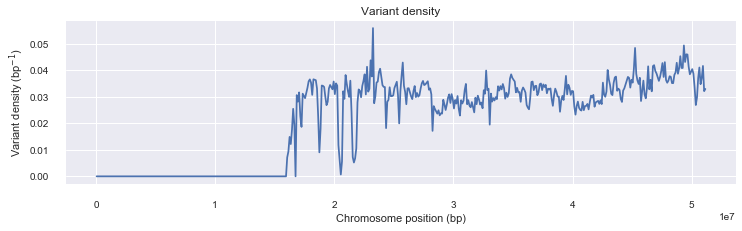

In [91]:
plot_windowed_variant_density(pos, window_size=100000, title='Variant density')

When working with large genotype arrays, scikit-allel has a [`GenotypeDaskArray`](@@TODO) class that is like the [`GenotypeArray`](@@TODO) class we met earlier but can handle data stored on-disk in HDF5 or Zarr files and compute over them without loading all data into memory.   

In [92]:
gt = allel.GenotypeDaskArray(callset_h1k['calldata/GT'])
gt

<GenotypeDaskArray shape=(1103547, 2504, 2) dtype=int8>

The main difference with the Dask-backed arrays is that you need to explicitly call `compute()` to run a computation, e.g.:

In [93]:
ac = gt.count_alleles(max_allele=8).compute()
ac

<AlleleCountsArray shape=(1103547, 9) dtype=int64>
5007    1    0    0    0    0    0    0    0
4976   32    0    0    0    0    0    0    0
4970   38    0    0    0    0    0    0    0
...
4969   39    0    0    0    0    0    0    0
5007    1    0    0    0    0    0    0    0
4989   19    0    0    0    0    0    0    0

## Further reading

If you have any questions or comments please feel free to drop a comment in below or [raise an issue on GitHub](https://github.com/cggh/scikit-allel/issues). If you're wondering where to go next, some of these articles may be of interest:

* [Installing Python for data analysis](http://alimanfoo.github.io/2017/05/18/installing-python.html)
* [A tour of scikit-allel](http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html)
* [Fast PCA](http://alimanfoo.github.io/2015/09/28/fast-pca.html)
* [Estimating F<sub>ST</sub>](http://alimanfoo.github.io/2015/09/21/estimating-fst.html)
* [Mendelian transmission](http://alimanfoo.github.io/2017/02/14/mendelian-transmission.html)

Further documentation about scikit-allel is available from the [scikit-allel API docs](http://scikit-allel.readthedocs.io/en/latest/).

## Post-script: changes from `vcfnp`

The new functions available in `scikit-allel` supercede a package I previously wrote for extracting data from VCF files called [`vcfnp`](@@TODO). I rewrote this functionality from the ground up and ported the functionality to `scikit-allel` for two main reasons. Firstly, `vcfnp` was slow and so you needed a cluster to parse big VCF files, which is obviously a pain. The new functions in `scikit-allel` should be up to ~40 times faster. Secondly, the `vcfnp` API was somewhat complicated, requiring three separate steps to get data from VCF into an HDF5 file or Zarr store. The new functions in `scikit-allel` hopefully simplify this process, enabling data to be extracted from VCF and loaded into any of a variety of storage containers via a single function call.

If you previously used `vcfnp` here are a few notes on some of the things that have changed.

* No need for separate function calls to extract data from variants and calldata fields, both can be extracted via a single call to `read_vcf()` or any of the `vcf_to_...()` functions described above.
* Data can be extracted from VCF and loaded into HDF5 with a single function call to `vcf_to_hdf5()`; i.e., no need to first extract parts of the data out to .npy files then load into HDF5.
* No need to use a cluster or do any parallelisation, it should be possible to run `vcf_to_hdf5()` or `vcf_to_zarr()` on a whole VCF on a half-decent desktop or laptop computer, although big VCF files might take a couple of hours and require a reasonably large hard disk.
* The default NumPy data type for string fields has changed to use 'object' dtype, which means that strings of any length will be stored automatically (i.e., no need to configure separate dtypes for each string field) and there will be no truncation of long strings.
* Previously in `vcfnp` the genotype calls were extracted into a special field called 'genotype' separate from the 'GT' calldata field if requested. In `scikit-allel` the default behaviour is to parse the 'GT' field as a 3-dimensional integer array and return simply as 'calldata/GT'. If you really want to process the 'GT' field as a string then you can override this by setting the type for 'calldata/GT' to 'S3' or 'object'.
* The "arity" argument in `vcfnp` is instead called "numbers" in scikit-allel, to match better with the terminology used in VCF meta-information headers.
* Genotype ploidy is now specified via the "numbers" argument, there is no special "ploidy" argument.
